# Meso

## Space in E-Cell4

We explained 3 fundamental elements (Model, World, Simulator) in E-Cell4. [Introduction](http://nbviewer.ipython.org/github/ecell/ecell4/blob/master/ipynb/Tutorials/Introduction.ipynb)

We also showed a simple simulation with ODE and stochastic method (Gillespie).
When we showed a simple simulation with ODE and Gillespie, we used the volume for **World**. [World and Simulator with ODE solver](http://nbviewer.ipython.org/github/ecell/ecell4/blob/master/ipynb/Tutorials/WorldSimBasics.ipynb)

What the space in E-Cell4 looks like?

In [1]:
from ecell4 import *

w1 = ode.ODEWorld(Real3(1, 1, 1))
w2 = gillespie.GillespieWorld(Real3(1, 1, 1))

We created a cube size1 on a side for ODE and Gillespie.  
In this case the volume only matters, that is


In [2]:
w3 = ode.ODEWorld(Real3(2, 0.5, 1))  # is almost equivalent to 'w1'
w4 = gillespie.GillespieWorld(Real3(2, 2, 0.25))  # is almost equivalent to 'w2'

This returns the same results. Because the volume is same 1.

This seems reasonable in homogeneous system, but the cell is NOT homogeneous.  
So we need to consider a space for molecular localization.

You can use several types of space and simulation methods in E-Cell4.
We show an example with spatial Gillespie method.


## Spatial Gillespie method

In E-Cell4, the Spatial Gillespie method is included in **meso** module
Let's start with **run_simulation** like ODE.

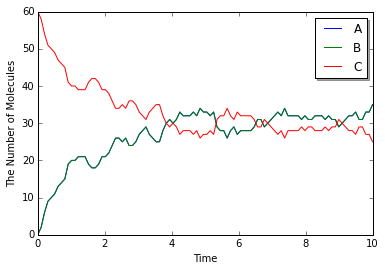

In [3]:
%matplotlib inline
import numpy
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

y = run_simulation(numpy.linspace(0, 10, 100), {'C': 60}, solver='meso')

$$
\frac{d\mathrm{C}}{dt}=0.01\frac{\mathrm{A}}{V}\frac{\mathrm{B}}{V}-0.3\frac{\mathrm{C}}{V}=0\\
0.01\left(60-\mathrm{C}\right)^2=0.3\mathrm{C}\times V\\
\mathrm{C}=30
$$

You will obtain almost the same result with ODE or Gillespie (may take longer time than ODE or Gillespie).
This is not surprising because **meso** module is almost same with Gillespie unless you give additional spatial parameter.
Next we will decompose **run_simulation**.


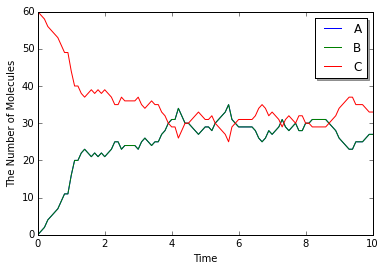

In [4]:
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = meso.MesoscopicWorld(Real3(1, 1, 1), Integer3(1, 1, 1))  # XXX: Point2
w.bind_to(m)  # XXX: Point1
w.add_molecules(Species('C'), 60)

sim = meso.MesoscopicSimulator(w)  # XXX: Point1
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

viz.plot_number_observer(obs)

This is nothing out of the ordinary one except **MesoscopicWorld** and  **MesoscopicSimulator**, but you can see some new elements.

First in **w.bind_to(m)** we asscociated **Model** to **World**.
In basic exercises, we did NOT do this.
In spatial method the Species attribute is important, so do NOT forget this.
All you have to do is giving **World** for **MesoscopicSimulator** instead.

Next, the important difference is the second argument for MesoscopicWorld i.e. **Integer3(1,1,1)**.
**ODEWorld** and **GillespieWorld** do NOT have this second argument.
Before we explain this, let's change this argument and run the simulation.


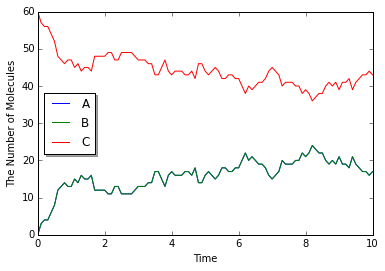

In [5]:
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = meso.MesoscopicWorld(Real3(1, 1, 1), Integer3(4, 4, 4))  # XXX: Point2
w.bind_to(m)  # XXX: Point1
w.add_molecules(Species('C'), 60)

sim = meso.MesoscopicSimulator(w)  # XXX: Point1
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

viz.plot_number_observer(obs)

You should have the different plot.  
If you increase the **Integer3**, you should have more different one.  
Actually this second argument means the number of spatical partitions.  
**meso** is almost same with **gillespie**, but **meso** divides the space into cuboids (we call these cuboids **Subvolume**) and each **Subvolume** has different molecular concentration by contrast **gillespie** has one uniform closed space.  
So in the preceding example, we divided **1** cube with sides **1** into **64(4x4x4)** cubes with sides **0.25(1/4)**.  
We threw 60 **C** species into the **World**, so each **Subvolume** has 1 species at most.  


## Defining molecular diffusion coefficient

Where the difference is coming from? This is because we do NOT concider about molecular diffusion coefficient, although we got a space with **meso**.  
To setup diffusion coefficient, use **Species** attribute **'D'** in a way described in ModelBasics.  
In [Introduction](http://nbviewer.ipython.org/github/ecell/ecell4/blob/master/ipynb/Tutorials/Introduction.ipynb) we used **add_species_attribute**, we can also use E-Cell4 special notation here.

In [6]:
with species_attributes():
    A | {'D': '1'}
    B | {'D': '1'}
    C | {'D': '1'}

    # A | B | C | {'D': '1'}  # means the same as above

get_model()

You can setup diffusion coefficient with `with species_attributes():`.  
Here we set all the diffusion coefficient with 1.  
Let's simulate this model again.  
Now you should have the almost same result with **gillespie** (the simulation will takes longer than **gillespie**) .  

How did the molecular diffusion work for the problem?  
Think about free diffusion (the diffusion coefficient of a Species is $D$) in 3D space.  
The unit of diffusion coefficient is the square of length divided by time like 
$\mathrm{\mu m}^2/s$ or $\mathrm{nm}^2/\mu s$ .

It is known that the average of the square of point distance from time $0$ to $t$ is equal to $6Dt$.  
Conversely the average of the time scale in a space with length scale $l$ is about $l^2/6D$.  

In the above case, the sibe of **Subvolume** is 0.25 and the diffusion coefficient is 1, so the time scale is about 0.01 sec.  
If the molecules of the **Species** **A** and **B** are in the same **Subvolume**, it takes about 1.5 sec to react, so in most cases the diffusion is faster than the reaction and the molecules move to other **Subvolume** even dissociated in the same **Subvolume**.  
The smaller $l$, the smaller **Subvolume**'s volume $l^3$, so the reaction rate after dissociation is faster, and the time of the diffusion and the transition between the **Subvolume** gets smaller too.


## Molecular localization

We have used **add_molecules** function to add molecules to **World** in the same manner as **ode** or **gillespie**.
Meanwhile in **MesoscopicWorld** you can put in molecules according to the spatial presentation.

In [7]:
from ecell4 import *

w = meso.MesoscopicWorld(Real3(1, 1, 1), Integer3(3, 3, 3))
w.add_molecules(Species('A'), 120)
w.add_molecules(Species('B'), 120, Integer3(1, 1, 1))

In **MesoscopicWorld**, you can set the **Subvolume** and the molecule locations by giving the third argument **Integer3** to **add_molecules**.
In the above example, the molecule type **A** spreads all over the space, but the molecule type **B** only locates the center of the **Subvolume**.  
To check this, use **num_molecules** function.

In [8]:
print(w.num_molecules(Species('B')))  # will print 120
print(w.num_molecules(Species('B'), Integer3(0, 0, 0)))  # will print 0
print(w.num_molecules(Species('B'), Integer3(1, 1, 1)))  # will print 120

120
0
120


Furthermore, if you have IPython Notebook environment, you can visualize the molecular localization with **ecell4.viz** module.

In [9]:
viz.plot_world(w, radius=0.01)

{u'A': '#a6cee3', u'B': '#1f78b4'}

**viz.plot_world** function visualize the location of the molecules in IPython Notebook cell by giving the **World**. You can set the molecule size with **radius**.  
Now you can set the molecular localization to the **World**, next let's simulate this.  
In the above example, we set the diffusion coefficient 1 and the World side 1, so 10 seconds is enough to stir this.  
After the simulation, check the result with calling **viz.plot_world** again.

## Molecular initial location and the reaction

This is an extreme example to check how the molecular localization affects the reaction.

In [27]:
from ecell4 import *

with species_attributes():
    A | B | C | {'D': '1'}

with reaction_rules():
    A + B > C | 0.01

m = get_model()
w = meso.MesoscopicWorld(Real3(10, 1, 1), Integer3(10, 1, 1))
w.bind_to(m)

This model consists only of a simple binding reaction.
The **World** is a long x axis cuboid.
And locate the molecules off-center.


In [28]:
w.add_molecules(Species('A'), 1200, Integer3(2, 0, 0))
w.add_molecules(Species('B'), 1200, Integer3(7, 0, 0))
viz.plot_world(w, radius=0.025)

{'A': '#a6cee3', 'B': '#1f78b4', 'C': '#b2df8a'}

On a different note, there is a reason not to set **Integer3(0,0,0)** or **Integer3(9,0,0)**.
In E-Cell4, basically we adopt periodic boundary condition for everything.
So the forementioned two **Subvolume**s are actually adjoining.

If you have the location expected, simulate it with **MesoscopicSimulator**.

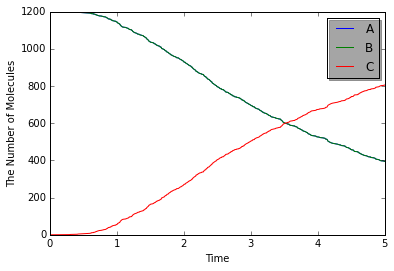

In [29]:
sim = meso.MesoscopicSimulator(w)
obs1 = NumberObserver(('A', 'B', 'C'))  # XXX: saves the numbers after every steps
sim.run(5, obs1)
viz.plot_number_observer(obs1)

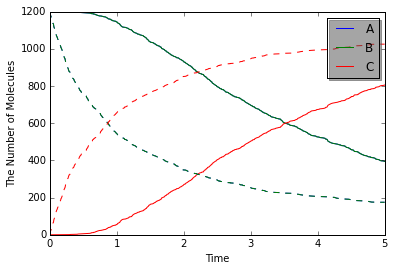

In [30]:
w = meso.MesoscopicWorld(Real3(10, 1, 1), Integer3(10, 1, 1))
w.bind_to(m)
w.add_molecules(Species('A'), 1200)
w.add_molecules(Species('B'), 1200)
sim = meso.MesoscopicSimulator(w)
obs2 = NumberObserver(('A', 'B', 'C'))  # XXX: saves the numbers after every steps
sim.run(5, obs2)
viz.plot_number_observer(obs1, "-", obs2, "--")

Do you have this plot?  
To check the result, we recommend that you locate the molecules homogeneously with **meso** or simulate with **gillespie**.

The solid line is biased case, and the dash line is non-biased.
The biased reaction is obviously slow.  
And you may notice that the time-series is different between the solid line and dash line.  
This is because it takes the molecule **A** and **B** some time to bound.  
Actually it takes $4^2/2(D_\mathrm{A}+D_\mathrm{B})=4$ seconds to move the initial distance between **A** and **B** (about 4).
